In [1]:
## First import general packages for running python analysis:
import os, h5py, datetime,pytz, yaml
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar
import pickle, glob

from scipy.interpolate import griddata
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares
from matplotlib import cm
from scipy.stats import binned_statistic_2d


from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

import csv
from math import *

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals.sites import site
from beamcals import beammap as bp
import beamcals.beam_autoprocessing as ba
gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')

# various gridding attempts
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

# import relevant stuff (for sims)

import pandas as pd
import math


# Defining anything I want to keep the same 

freqs = 800.0*np.ones(1024) + (-400/1024.)*np.arange(1024)


#basedir = '/hirax/GBO_Analysis_Outputs/2023_SpringSummer_products/'
basedir = '/hirax/GBO_Analysis_Outputs/'
fitdir=basedir+'main_beam_fits/'
ymldir = basedir+'concat_config_files/'
pckldir = basedir+'flight_pickles/'
ampdir = basedir+'amplitude_corrections/'
beamdir = basedir+'beam_pickles/'
polbeamdir = '/hirax/GBO_Analysis_Outputs/beam_pickles/beam_pickles_polar/'

dronedir='/hirax/all_drone_data/datcon_csv/'
fltyaml = '/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml'


# Plotting standards
fsz = 16 # fontsize for labels and legends
ccm = cm.magma # use magma for color maps

## Useful functions
def get_flightinfo(fly):
    with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
        documents = yaml.safe_load(fff)
    flights = documents["flight_info"]["flights"]
    
    for fi in range(0,len(documents["flight_info"]["flights"])):
        if fly == flights[fi]: f = fi
    
    if polarn[f]=='N':
        pols = N_pols
        cpols = E_pols
    else:
        pols = E_pols
        cpols = N_pols
    return polarn[f], pols, cpols, attns[f], f


def m_to_FWHM(d):
    h = 177.0 # meters
    sig = np.degrees(np.arctan(d/h))
    fwhm = 2.355*sig
    return fwhm

def get_polar_slice(theta,phi,val=0.0,direction='t'): # assume val in angle
    
    if direction=='p':
        tol = abs(phi[0,1] - phi[0,0])
        N = len(phi[0,:]) #figure out the importance of this 
        #ok = True
        #while(ok):
        sliceIndex1 = np.where(
            (phi[0,:] < (val + tol)) & 
            (phi[0,:] > (val - tol)))[0][0]
        sliceIndex2 = np.where(
            (phi[0,:] < (val + tol)) & 
            (phi[0,:] > (val - tol)))[0][0]

        
    if direction=='t': 
        tol = abs(theta[1,0] - theta[0,0])/1.5
        N = len(theta[:,0]) #figure out the importance of this 
        #ok = True
        #while(ok):
        sliceIndex1 = np.where(
            (theta[:,0] < (val + tol)) & 
            (theta[:,0] > (val - tol)))[0][0]
        sliceIndex2 = np.where(
            (theta[:,0] < (np.pi + val + tol)) & 
            (theta[:,0] > (np.pi + val - tol)))[0][0]
        
    return sliceIndex1, sliceIndex2

def get_slice_xy(xes,yes,val,tol=1,ax='x'):
    if ax=='x':
        col = np.where((xes < val+tol) & (xes > val-tol))[0]
    if ax=='y':
        col = np.where((yes < val+tol) & (yes > val-tol))[0]
    return col


with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]
N_pols = documents["flag_info"]["N_pols"]
E_pols = documents["flag_info"]["E_pols"]
polarn = documents["flight_info"]["pols"]
attns = documents["flight_info"]["attns"]
masks = documents["flight_info"]["masks"]
good_freqs = documents["freq_info"]["good_freqs"]

pcklarr=np.sort(os.listdir(pckldir))
gfitarr=np.sort(os.listdir(fitdir))
amparr=np.sort(os.listdir(ampdir))
print(gfitarr,amparr)

Npolflights = ['618','619','625','646','647','533']
Epolflights = ['620','648','649','535']
NF = len(Npolflights)
NE = len(Epolflights)
F = NF+NE
fi_i =650

find=900
sz=80

['FLY533_20210826T182904Z_2dGauss_and_Airy_Params.npz'
 'FLY534_20210826T185621Z_2dGauss_and_Airy_Params.npz'
 'FLY535_20210826T192056Z_2dGauss_and_Airy_Params.npz'
 'FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz'
 'FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz'
 'FLY620_20211021T192212Z_2dGauss_and_Airy_Params.npz'
 'FLY623_20211021T203206Z_2dGauss_and_Airy_Params.npz'
 'FLY625_20211021T214028Z_2dGauss_and_Airy_Params.npz'
 'FLY646_20211022T183659Z_2dGauss_and_Airy_Params.npz'
 'FLY647_20211022T185749Z_2dGauss_and_Airy_Params.npz'
 'FLY648_20211022T191922Z_2dGauss_and_Airy_Params.npz'
 'FLY649_20211022T194308Z_2dGauss_and_Airy_Params.npz'] ['FLY533_Corrected_amplitudes.pkl' 'FLY534_Corrected_amplitudes.pkl'
 'FLY535_Corrected_amplitudes.pkl' 'FLY618_Corrected_amplitudes.pkl'
 'FLY619_Corrected_amplitudes.pkl' 'FLY620_Corrected_amplitudes.pkl'
 'FLY623_Corrected_amplitudes.pkl' 'FLY625_Corrected_amplitudes.pkl'
 'FLY646_Corrected_amplitudes.pkl' 'FLY647_Corrected_amplitudes

In [2]:
# set up relevant read-in functions from Emily's code

def lintodb_V(mags):
    mag_=10*np.log10(np.array(mags))
    return(mag_)

def lintodb(mags):
    mag_=20*np.log10(np.array(mags))
    return(mag_)

def find_indx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return(idx)

def cstreader(file):
    data = open(file).readlines()[2::]
    theta = []
    phi = []
    gainTheta = []
    gainPhi = []
    for row in data:
        theta.append(float(row.rsplit()[0]))
        phi.append(float(row.rsplit()[1]))
        gainTheta.append(float(row.rsplit()[3]))
        gainPhi.append(float(row.rsplit()[5]))
    df = pd.DataFrame({'theta':theta, 'phi':phi, 'gain(theta)':gainTheta, 'gain(phi)':gainPhi})
    return(df)

def Theta_0(df):
    df1 = df.truncate(before=find_indx(df['phi'], 0), after=find_indx(df['phi'], 1)-1)
    return(df1)
def Theta_90(df):
    df1 = df.truncate(before=find_indx(df['phi'], -90), after=find_indx(df['phi'], -89)-1)
    return(df1)

def Theta_angle(df, angle):
    df1 = df.truncate(before=find_indx(df['phi'], angle), after=find_indx(df['phi'], angle+1)-1)
    return(df1)

class cst_beam_sims:
    def __init__(self, file):
        df = cstreader(file)
        self.vars = variables(df)
    def plot_CoPol(self):
        plot(self.vars.e_co[0], lintodb(self.vars.e_co[1]), label = 'E co')
        plot(self.vars.h_co[0], lintodb(self.vars.h_co[1]), label = 'H co')
    def plot_Crp(self):
        plot(self.vars.e_crp[0], lintodb(self.vars.e_crp[1]), label = 'E crp')
        plot(self.vars.h_crp[0], lintodb(self.vars.h_crp[1]), label = 'H crp')
    def plot_Hco(self):
        plot(self.vars.h_co[0], lintodb(self.vars.h_co[1]), label = 'H co')
    def plot_Eco(self):
        plot(self.vars.e_co[0], lintodb(self.vars.e_co[1]), label = 'E co')
        
class variables:
    def __init__(self, df):
        #seems mised up but also seems to work?
        
        self.e_co = [Theta_90(df)['theta'], Theta_90(df)['gain(phi)']]
        self.e_crp = [Theta_90(df)['theta'], Theta_90(df)['gain(theta)']]
        self.h_co = [Theta_0(df)['theta'], Theta_0(df)['gain(phi)']]
        self.h_crp = [Theta_0(df)['theta'], Theta_0(df)['gain(theta)']]

        self.e_co_angle, self.e_co_gain = self.e_co[0], self.e_co[1]
        self.e_crp_angle, self.e_crp_gain = self.e_crp[0], self.e_crp[1]
        self.h_co_angle, self.h_co_gain = self.h_co[0], self.h_co[1]
        self.h_crp_angle, self.h_crp_gain = self.h_crp[0], self.h_crp[1]

In [3]:
# read in sims data - make a sims array of that data

dfs_sims = {}
for freq in np.arange(400,850,50):
    dfs_sims[freq] = {}
    simfile = '/hirax/cst/hirax_gbo_v1_legs/Export/Farfield/farfield_(f='\
            +str(freq/1e3)+')_[1].txt'
    
    df = cstreader(simfile)
    indicesofinterest = [i for i in range(len(df['theta'])) if -90<df['theta'][i]<90]
    r = np.sqrt(df['gain(theta)'][indicesofinterest]**2+df['gain(phi)'][indicesofinterest]**2)
    r1 = df['gain(theta)'][indicesofinterest]
    r2 = df['gain(phi)'][indicesofinterest]
    x = np.cos(np.deg2rad(df['phi'][indicesofinterest]))*np.sin(np.deg2rad(df['theta'][indicesofinterest]))
    y = np.sin(np.deg2rad(df['phi'][indicesofinterest]))*np.sin(np.deg2rad(df['theta'][indicesofinterest]))

    dfs_sims[freq]['oneD'] = cst_beam_sims(simfile)
    dfs_sims[freq]['df'] = df
    dfs_sims[freq]['mag'] = [r,r2,r1]
    dfs_sims[freq]['position'] = [np.rad2deg(x),np.rad2deg(y)] #says x and y but is still in degrees

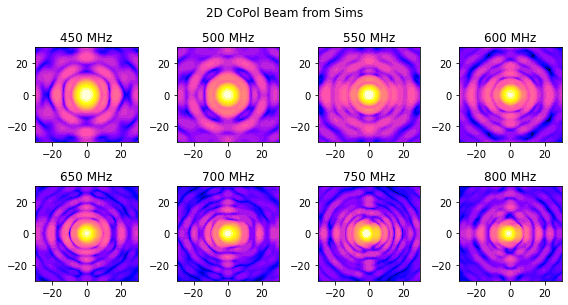

In [4]:
# plot sims data as check

fig = figure(figsize = (8, 4))
counter = 1

for freq in np.arange(450,850,50):
    ax = fig.add_subplot(2, 4, counter)
    ax.tricontourf(dfs_sims[freq]['position'][0],dfs_sims[freq]['position'][1], lintodb_V(dfs_sims[freq]['mag'][1]), 50, vmin = -10, cmap = 'gnuplot2')
    ax.set_title(str(freq)+' MHz')
    ax.set_xlim(-30,30)
    ax.set_ylim(-30,30)
    counter += 1
tight_layout()
suptitle('2D CoPol Beam from Sims', y=1.05)
show()


In [7]:
# linearly interpolate to a finer grid - keep in case its useful
## interpolate sims onto a 2D grid used for flight data
#x,y = dfs_sims[freq]['position'][0],dfs_sims[freq]['position'][1]
#z = dfs_sims[freq]['mag'][1]

#X,Y = np.meshgrid(np.linspace(-30,30,1000), np.linspace(-30,30,1000))

#Z = griddata((x,y), z, (X,Y))

## plot sims data at 450MHz
#imshow(10*np.log10(Z), extent=(-40,40,-40,40))
#show()

In [9]:
## This just takes the first frequency, and I will (without any gridding):
# 1. plot the sim
# 2. plot a slice of the sim
# 3. plot the polar data
# 4. plot a slice of the polar data

# What I learned: pandas data needs to be put into a numpy array for where() calls

<ipython-input-2-ad16ac32a46e>:8: RuntimeWarning: invalid value encountered in log10
  mag_=20*np.log10(np.array(mags))


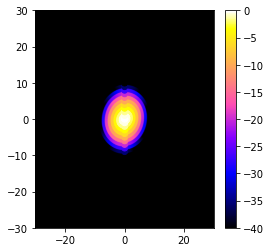

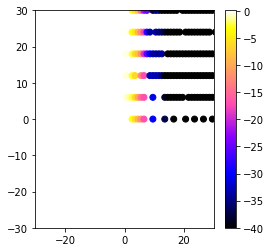

In [10]:
colorz = pu.cm_to_discrete(ccm, 16)

# plot the sim
freq = 450
amp = max(dfs_sims[freq]['mag'][1])
xpos = dfs_sims[freq]['position'][0].to_numpy()
ypos = dfs_sims[freq]['position'][1].to_numpy()
zpos = (dfs_sims[freq]['mag'][1].to_numpy()/amp)**2


figure(figsize = (4,4))
plt.scatter(xpos,ypos, c=lintodb(zpos),cmap = 'gnuplot2',vmin=-40)
xlim(-30,30)
ylim(-30,30)
plt.colorbar()

# plot some beam data
copoldir = 'N'
pols = N_pols
chind = pols[0]

picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)

ppos = np.degrees(ptest.d1_centers_grid[:,:,chind])
tpos = np.degrees(ptest.d0_centers_grid[:,:,chind])
dzpos = ptest.V_LC_operation[:,:,0,chind]


ppos_flat = ppos.ravel()
tpos_flat = tpos.ravel()
dzpos_flat = dzpos.ravel()
gi = np.where(np.isfinite(dzpos_flat))[0] 
    
figure(figsize = (4,4))
plt.scatter(ppos_flat,tpos_flat, c=lintodb(dzpos_flat),cmap = 'gnuplot2',vmin=-40)
xlim(-30,30)
ylim(-30,30)
plt.colorbar()



fitfit 6.915892718026059
1 fitfit 7.759966779949128
3 fitfit 7.206515936705797
11 fitfit 7.763049037856612
15 fitfit 7.1986648367578825


<ipython-input-11-d203eabd602b>:49: RuntimeWarning: invalid value encountered in log10
  axs.plot(pposc,10*np.log10(dzposc),color=colorz[chind],marker='.',linestyle='None')
<ipython-input-11-d203eabd602b>:49: RuntimeWarning: invalid value encountered in log10
  axs.plot(pposc,10*np.log10(dzposc),color=colorz[chind],marker='.',linestyle='None')


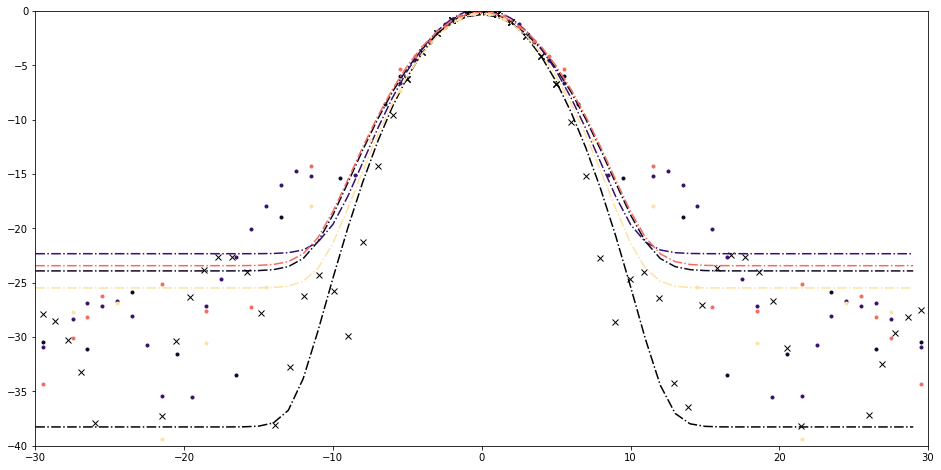

In [11]:
fig, axs = plt.subplots(1,1,figsize=(16,8))

cc = get_slice_xy(xpos,ypos,0.0,tol=0.1,ax='y') # this should be a horizontal slice
axs.plot(xpos[cc],10*np.log10(zpos[cc]),color='black',marker='x',linestyle='None')

# 1d fit to check
def Gauss_1d_opt(P,x,V):
    Gauss_eval = Gauss_1d_func(P,x)
    return Gauss_eval-V

def Gauss_1d_func(P,x):
    amp,x0,xsig,c=P
    xx = ((x-x0)**2)/(2*(xsig**2))
    return amp*np.exp(-1.0*(xx))+c

pG = [1.0, 0.0, 7.0, 0.0]
input_data=np.array([xpos[cc],zpos[cc]])
G_popt = least_squares(Gauss_1d_opt,x0=pG,method='trf',args=input_data).x
print('fitfit', 2.355*G_popt[2])
xes = np.arange(-30,30)
yes = Gauss_1d_func(G_popt,xes)

# plot fit for the sim data
axs.plot(xes,10*np.log10(yes),color='black',linestyle='-.')

# set which pol:
copoldir = 'N'
pols = N_pols
chind = pols[1]

find = 896 # 450.0

picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)

  
    
for p,chind in enumerate(N_pols):
    ppos = np.degrees(ptest.d1_centers_grid[:,:,chind])
    tpos = np.degrees(ptest.d0_centers_grid[:,:,chind])
    dzpos = ptest.V_LC_operation[:,:,0,chind]
    
    cc1,cc2 = get_polar_slice(tpos,ppos,val=0.0,direction='t')

    pposc = np.concatenate((ppos[cc1,:],-1.0*ppos[cc2,:]))
    dzposc = np.concatenate((dzpos[cc1,:],dzpos[cc2,:]))
    gi = np.where(np.isfinite(dzposc))[0] 
    axs.plot(pposc,10*np.log10(dzposc),color=colorz[chind],marker='.',linestyle='None')
    axs.set_xlim(-30,30)
    axs.set_ylim(-40,0)
    
    
    input_data=np.array([pposc[gi],dzposc[gi]])
    G_popt = least_squares(Gauss_1d_opt,x0=pG,method='trf',args=input_data).x
    print(chind,'fitfit', 2.355*G_popt[2])
    yes = Gauss_1d_func(G_popt,xes)

    ## plot fit for the sim data
    axs.plot(xes,10*np.log10(yes),color=colorz[chind],linestyle='-.')

plt.show()

sim fit 6.915892718026059
1 fitfit 7.438251997526922
3 fitfit 7.855246149254262
11 fitfit 7.949960172402117
15 fitfit 6.961449350504997


<ipython-input-12-81b733553c46>:51: RuntimeWarning: invalid value encountered in log10
  axs.plot(xd_flat[cc],10*np.log10(dzpos_flat[cc]),color=colorz[chind],marker='o',linestyle='None')
<ipython-input-12-81b733553c46>:51: RuntimeWarning: invalid value encountered in log10
  axs.plot(xd_flat[cc],10*np.log10(dzpos_flat[cc]),color=colorz[chind],marker='o',linestyle='None')
<ipython-input-12-81b733553c46>:51: RuntimeWarning: invalid value encountered in log10
  axs.plot(xd_flat[cc],10*np.log10(dzpos_flat[cc]),color=colorz[chind],marker='o',linestyle='None')
<ipython-input-12-81b733553c46>:51: RuntimeWarning: invalid value encountered in log10
  axs.plot(xd_flat[cc],10*np.log10(dzpos_flat[cc]),color=colorz[chind],marker='o',linestyle='None')


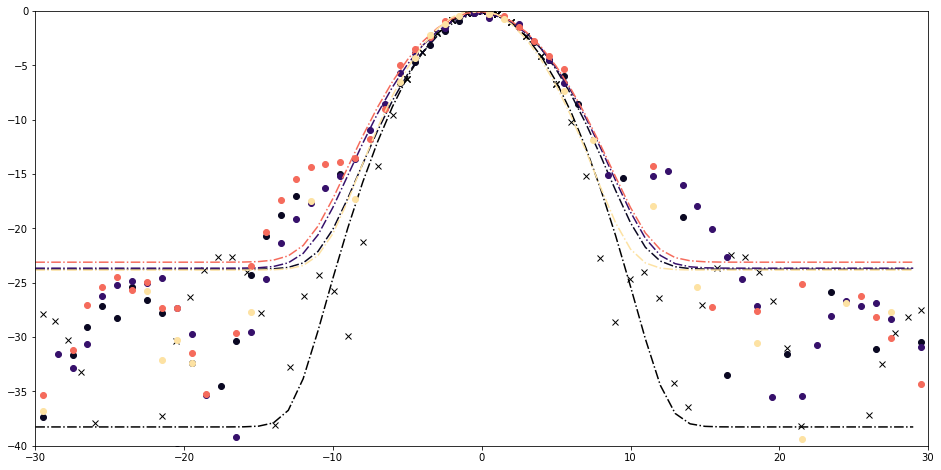

In [12]:
## Check if I define an x,y from the theta,phi in the polar coords
# what happens to the map, slice, 1D fits

# plot some beam data
copoldir = 'N'
pols = N_pols
chind = pols[1]

picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)


fig, axs = plt.subplots(1,1,figsize=(16,8))

cc = get_slice_xy(xpos,ypos,0.0,tol=0.1,ax='y') # this should be a horizontal slice
axs.plot(xpos[cc],10*np.log10(zpos[cc]),color='black',marker='x',linestyle='None')

pG = [1.0, 0.0, 7.0, 0.0]
input_data=np.array([xpos[cc],zpos[cc]])
G_sim = least_squares(Gauss_1d_opt,x0=pG,method='trf',args=input_data).x
print('sim fit', 2.355*G_sim[2])

xes = np.arange(-30,30)
yes = Gauss_1d_func(G_sim,xes)

# plot fit for the sim data
axs.plot(xes,10*np.log10(yes),color='black',linestyle='-.')


for p,chind in enumerate(N_pols): 
    ppos = np.degrees(ptest.d1_centers_grid[:,:,chind])
    tpos = ptest.d0_centers_grid[:,:,chind]
    dzpos = ptest.V_LC_operation[:,:,0,chind]

    xd = ppos*np.cos(tpos)
    yd = ppos*np.sin(tpos)

    xd_flat = xd.ravel()
    yd_flat = yd.ravel()
    dzpos_flat = dzpos.ravel()
    gi = np.where(np.isfinite(dzpos_flat))[0] 
    
    #figure(figsize = (4,4))
    #plt.scatter(xd_flat,yd_flat, c=lintodb(dzpos_flat),cmap = 'gnuplot2',vmin=-40)
    #xlim(-30,30)
    #ylim(-30,30)
    #plt.colorbar()

    cc = get_slice_xy(xd_flat,yd_flat,0.0,tol=0.1,ax='y') # this should be a horizontal slice
    axs.plot(xd_flat[cc],10*np.log10(dzpos_flat[cc]),color=colorz[chind],marker='o',linestyle='None')
    axs.set_xlim(-30,30)
    axs.set_ylim(-40,0)

    # 1D fit
    pG = [1.0, 0.0, 3.0, 0.5]
    gi = np.where(np.isfinite(dzpos_flat[cc]))[0] 
    input_data=np.array([xd_flat[cc[gi]],dzpos_flat[cc[gi]]])
    G_popt = least_squares(Gauss_1d_opt,x0=G_sim,method='trf',args=input_data).x
    
    yes = Gauss_1d_func(G_popt,xes)
    axs.plot(xes,10*np.log10(yes),color=colorz[chind],linestyle='-.')
    
    print(chind,'fitfit', 2.355*G_popt[2])

plt.show()

<ipython-input-13-09ca1e29d2cb>:20: RuntimeWarning: invalid value encountered in log10
  axs.plot(pposc,10*np.log10(dzposc),color=colorz[chind],marker='+',linestyle='None')
<ipython-input-13-09ca1e29d2cb>:22: RuntimeWarning: invalid value encountered in log10
  axs.plot(-1.0*ppos[cc2,:],10*np.log10(dzpos[cc2,:]),color=colorz[chind],marker='x',linestyle='None')
<ipython-input-13-09ca1e29d2cb>:33: RuntimeWarning: invalid value encountered in log10
  axs.plot(xd_flat[cc],10*np.log10(dzpos_flat[cc]),color=colorz[chind],marker='.',linestyle='None')
<ipython-input-13-09ca1e29d2cb>:20: RuntimeWarning: invalid value encountered in log10
  axs.plot(pposc,10*np.log10(dzposc),color=colorz[chind],marker='+',linestyle='None')
<ipython-input-13-09ca1e29d2cb>:21: RuntimeWarning: invalid value encountered in log10
  axs.plot(ppos[cc1,:],10*np.log10(dzpos[cc1,:]),color=colorz[chind],marker='x',linestyle='None')
<ipython-input-13-09ca1e29d2cb>:22: RuntimeWarning: invalid value encountered in log10
  axs

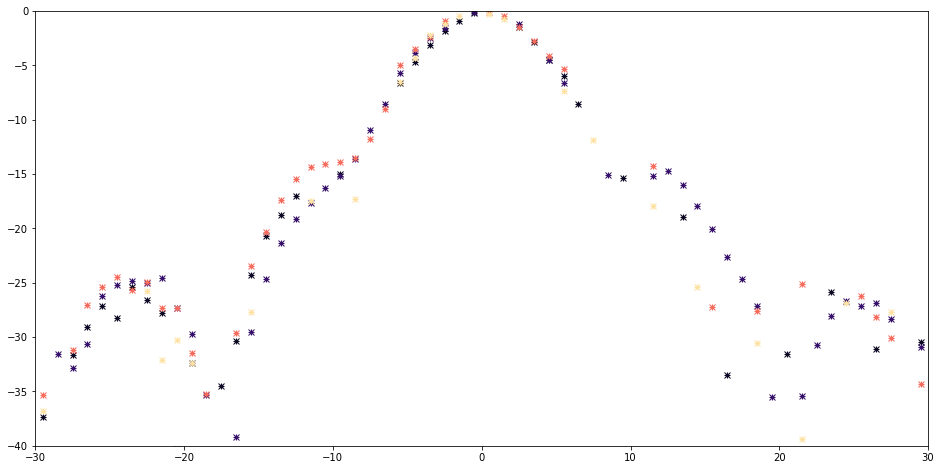

In [13]:
# plot some beam data
copoldir = 'N'
pols = N_pols
chind = pols[1]

picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
fig, axs = plt.subplots(1,1,figsize=(16,8))
for p,chind in enumerate(N_pols):
    ppos = np.degrees(ptest.d1_centers_grid[:,:,chind])
    tpos = ptest.d0_centers_grid[:,:,chind]
    dzpos = ptest.V_LC_operation[:,:,0,chind]
    
    cc1,cc2 = get_polar_slice(tpos,ppos,val=0.0,direction='t')
        
    pposc = np.concatenate((ppos[cc1,:],-1.0*ppos[cc2,:]))
    dzposc = np.concatenate((dzpos[cc1,:],dzpos[cc2,:]))
    axs.plot(pposc,10*np.log10(dzposc),color=colorz[chind],marker='+',linestyle='None')
    axs.plot(ppos[cc1,:],10*np.log10(dzpos[cc1,:]),color=colorz[chind],marker='x',linestyle='None')
    axs.plot(-1.0*ppos[cc2,:],10*np.log10(dzpos[cc2,:]),color=colorz[chind],marker='x',linestyle='None')

    xd = ppos*np.cos(tpos)
    yd = ppos*np.sin(tpos)

    xd_flat = xd.ravel()
    yd_flat = yd.ravel()
    dzpos_flat = dzpos.ravel()

    cc = get_slice_xy(xd_flat,yd_flat,0.0,tol=0.01,ax='y') # this should be a horizontal slice

    axs.plot(xd_flat[cc],10*np.log10(dzpos_flat[cc]),color=colorz[chind],marker='.',linestyle='None')
    axs.set_xlim(-30,30)
    axs.set_ylim(-40,0)
plt.show()

### FWHM and fitting comparisons ###

Freqs:  450 450.0
SIM, X width:  6.7388329569482845 Y width:  7.719266259816694
Calculated:  1 X width:  7.37361134190633 Y width:  7.125583839741585
From Cartesian  1 X width:  7.491343742766687 Y width:  7.10243022105204
Calculated:  3 X width:  7.57864184341499 Y width:  7.144942853562009
From Cartesian  3 X width:  7.51513233912081 Y width:  7.129789640407691
Calculated:  11 X width:  7.808323357710864 Y width:  7.4838331610122335
From Cartesian  11 X width:  8.034099110641034 Y width:  7.43561221979902
Calculated:  15 X width:  7.15258804711774 Y width:  7.0079797191040365
From Cartesian  15 X width:  7.101108496053756 Y width:  7.02613352884362


<ipython-input-14-80681373919c>:63: RuntimeWarning: invalid value encountered in log10
  axs.plot(xd_flat[cc],10*np.log10(dzpos_flat[cc]),color=colorz[chind],marker='.',linestyle='None')
<ipython-input-14-80681373919c>:63: RuntimeWarning: invalid value encountered in log10
  axs.plot(xd_flat[cc],10*np.log10(dzpos_flat[cc]),color=colorz[chind],marker='.',linestyle='None')
<ipython-input-14-80681373919c>:63: RuntimeWarning: invalid value encountered in log10
  axs.plot(xd_flat[cc],10*np.log10(dzpos_flat[cc]),color=colorz[chind],marker='.',linestyle='None')
<ipython-input-14-80681373919c>:63: RuntimeWarning: invalid value encountered in log10
  axs.plot(xd_flat[cc],10*np.log10(dzpos_flat[cc]),color=colorz[chind],marker='.',linestyle='None')


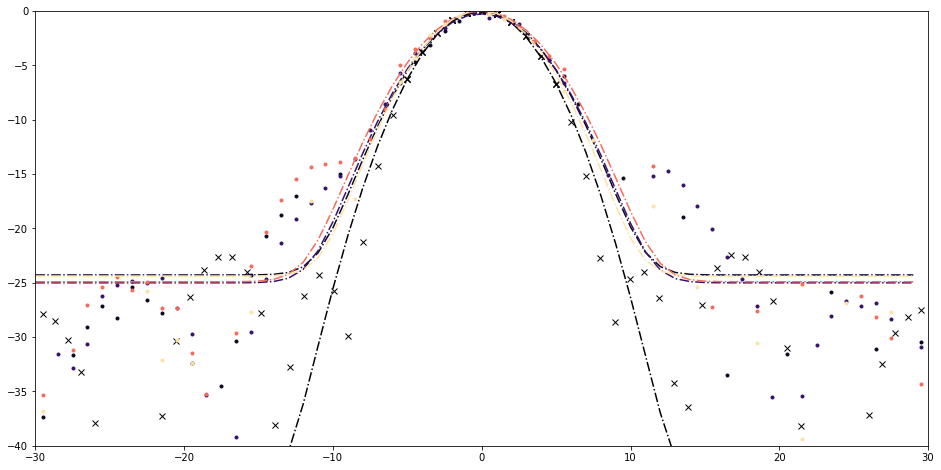

Freqs:  500 500.0
SIM, X width:  6.160759609642246 Y width:  6.574161769583983
Calculated:  1 X width:  6.784026575256233 Y width:  6.8118573851500726
From Cartesian  1 X width:  6.891195369344027 Y width:  6.821358594132389
Calculated:  3 X width:  6.7682976732424045 Y width:  6.678885212495827
From Cartesian  3 X width:  6.773807980766602 Y width:  6.653806390149049
Calculated:  11 X width:  7.125520546875769 Y width:  7.115019711167935
From Cartesian  11 X width:  7.255735121698494 Y width:  7.133092048506019
Calculated:  15 X width:  6.303876990339373 Y width:  6.715672616258636
From Cartesian  15 X width:  6.326666540678155 Y width:  6.708393526670881


<ipython-input-14-80681373919c>:63: RuntimeWarning: invalid value encountered in log10
  axs.plot(xd_flat[cc],10*np.log10(dzpos_flat[cc]),color=colorz[chind],marker='.',linestyle='None')
<ipython-input-14-80681373919c>:63: RuntimeWarning: invalid value encountered in log10
  axs.plot(xd_flat[cc],10*np.log10(dzpos_flat[cc]),color=colorz[chind],marker='.',linestyle='None')
<ipython-input-14-80681373919c>:63: RuntimeWarning: invalid value encountered in log10
  axs.plot(xd_flat[cc],10*np.log10(dzpos_flat[cc]),color=colorz[chind],marker='.',linestyle='None')


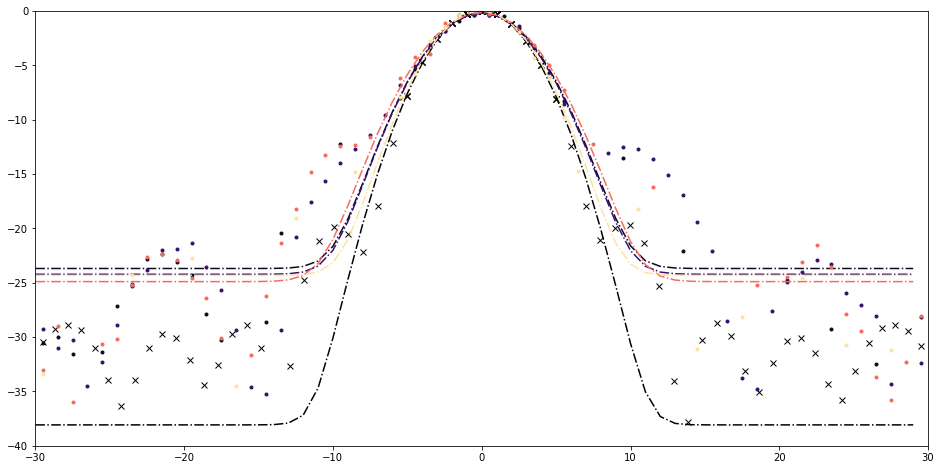

Freqs:  550 550.390625
SIM, X width:  5.676755711746169 Y width:  5.857778657858843
Calculated:  1 X width:  6.266242663224179 Y width:  6.586298019629109
From Cartesian  1 X width:  6.427031747532831 Y width:  6.6080701531303285
Calculated:  3 X width:  6.105378527753005 Y width:  6.144938053596705
From Cartesian  3 X width:  6.144666798323576 Y width:  6.141031199540902
Calculated:  11 X width:  6.470197051039323 Y width:  6.759704790483808
From Cartesian  11 X width:  6.63271499535769 Y width:  6.747674187164752
Calculated:  15 X width:  5.780678582797924 Y width:  6.480836720370915
From Cartesian  15 X width:  5.856977137234703 Y width:  6.527557322677646


<ipython-input-14-80681373919c>:63: RuntimeWarning: invalid value encountered in log10
  axs.plot(xd_flat[cc],10*np.log10(dzpos_flat[cc]),color=colorz[chind],marker='.',linestyle='None')
<ipython-input-14-80681373919c>:63: RuntimeWarning: invalid value encountered in log10
  axs.plot(xd_flat[cc],10*np.log10(dzpos_flat[cc]),color=colorz[chind],marker='.',linestyle='None')
<ipython-input-14-80681373919c>:63: RuntimeWarning: invalid value encountered in log10
  axs.plot(xd_flat[cc],10*np.log10(dzpos_flat[cc]),color=colorz[chind],marker='.',linestyle='None')
<ipython-input-14-80681373919c>:63: RuntimeWarning: invalid value encountered in log10
  axs.plot(xd_flat[cc],10*np.log10(dzpos_flat[cc]),color=colorz[chind],marker='.',linestyle='None')


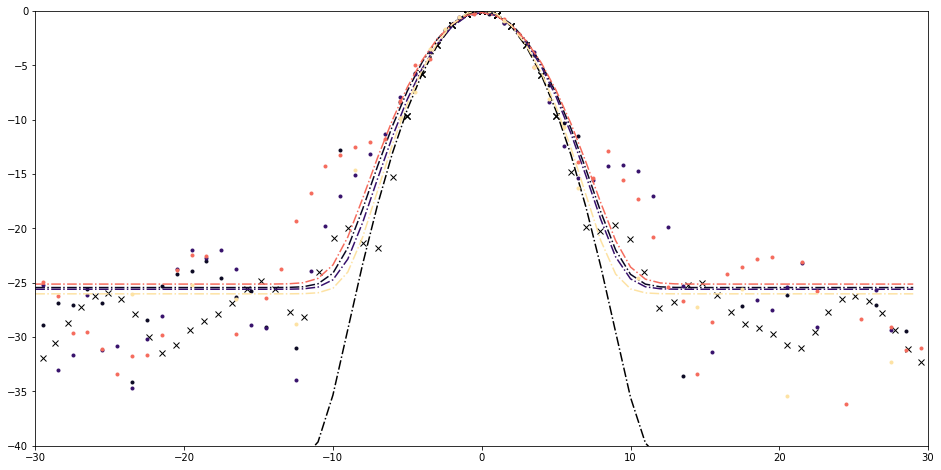

Freqs:  600 598.046875
SIM, X width:  5.252676655559062 Y width:  5.410572425233073
Calculated:  1 X width:  6.819454728747227 Y width:  6.744721206344857
From Cartesian  1 X width:  6.775772833010134 Y width:  6.774738477598767
Calculated:  3 X width:  6.615486406620168 Y width:  6.6782301292897825
From Cartesian  3 X width:  6.62914840322824 Y width:  6.326392462670597
Calculated:  11 X width:  6.957460543105177 Y width:  6.851948018004985
From Cartesian  11 X width:  6.793508167806846 Y width:  6.974852578013352
Calculated:  15 X width:  6.103472397704667 Y width:  6.736982114916508
From Cartesian  15 X width:  6.161057269865688 Y width:  6.863247961504354


<ipython-input-14-80681373919c>:63: RuntimeWarning: invalid value encountered in log10
  axs.plot(xd_flat[cc],10*np.log10(dzpos_flat[cc]),color=colorz[chind],marker='.',linestyle='None')
<ipython-input-14-80681373919c>:63: RuntimeWarning: invalid value encountered in log10
  axs.plot(xd_flat[cc],10*np.log10(dzpos_flat[cc]),color=colorz[chind],marker='.',linestyle='None')
<ipython-input-14-80681373919c>:63: RuntimeWarning: invalid value encountered in log10
  axs.plot(xd_flat[cc],10*np.log10(dzpos_flat[cc]),color=colorz[chind],marker='.',linestyle='None')
<ipython-input-14-80681373919c>:63: RuntimeWarning: invalid value encountered in log10
  axs.plot(xd_flat[cc],10*np.log10(dzpos_flat[cc]),color=colorz[chind],marker='.',linestyle='None')


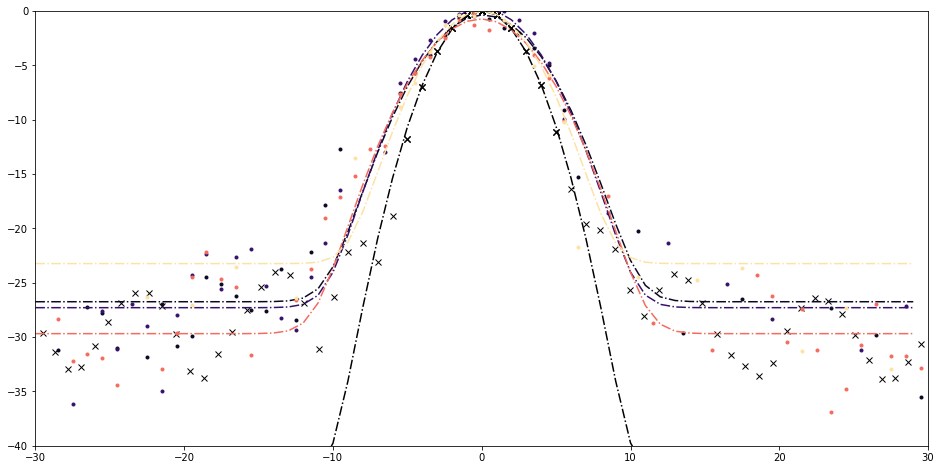

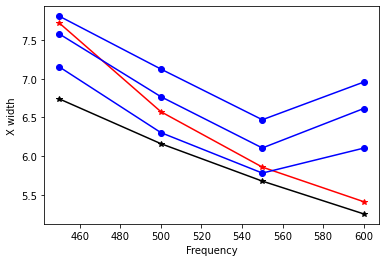

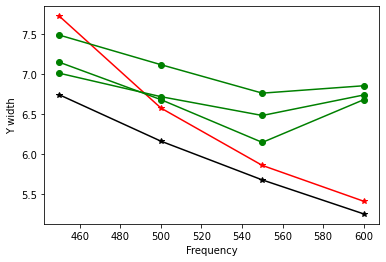

In [14]:
# Now that I theoretically know what I'm doing, let's first fit FWHMs and compare
# per frequency, per input, all inputs

# also, for shits and giggles, print out the FWHM computed from the coadded maps in cartesian

coadded = np.load('/hirax/GBO_Analysis_Outputs/Coadded_2dGauss_and_Airy_Param_w_errs.npz')
    
    
finds = [896,768,639,517]
simfr = [450,500,550,600]

fwhmarr = np.zeros([4,2,5])

for ff,find in enumerate(finds):
    print('Freqs: ', simfr[ff],freqs[find])
    
    # Sim first
    freq = simfr[ff]
    fig, axs = plt.subplots(1,1,figsize=(16,8))
    amp = max(dfs_sims[freq]['mag'][1])
    xpos = dfs_sims[freq]['position'][0].to_numpy()
    ypos = dfs_sims[freq]['position'][1].to_numpy()
    zpos = (dfs_sims[freq]['mag'][1].to_numpy()/amp)**2
 
    cc = get_slice_xy(xpos,ypos,0.0,tol=0.1,ax='y') # this should be a horizontal slice
    axs.plot(xpos[cc],10*np.log10(zpos[cc]),color='black',marker='x',linestyle='None')
    
    pG = [1.0, 0.0, 3.0, 0.0, 3.0, 0.0]
    input_data=np.array([xpos,ypos,zpos])
    G_popt = least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data).x
    print('SIM, X width: ', 2.335*G_popt[2], 'Y width: ', 2.335*G_popt[4])
    fwhmarr[ff,:,0] = [2.335*G_popt[2],2.335*G_popt[4]]
    
    xes = np.arange(-30,30)
    yes = np.zeros(len(xes))
    fitd = fu.Gauss_2d_LC_func(G_popt,xes,yes)

    # plot fit for the sim data
    axs.plot(xes,10*np.log10(fitd),color='black',linestyle='-.')
    
    # N pol next
    copoldir = 'N'
    pols = N_pols

    picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
    with open(picklefile, 'rb') as inp:
        ptest = pickle.load(inp)

    for p,chind in enumerate(N_pols): 
        ppos = np.degrees(ptest.d1_centers_grid[:,:,chind])
        tpos = ptest.d0_centers_grid[:,:,chind]
        dzpos = ptest.V_LC_operation[:,:,0,chind]

        xd = ppos*np.cos(tpos)
        yd = ppos*np.sin(tpos)

        xd_flat = xd.ravel()
        yd_flat = yd.ravel()
        dzpos_flat = dzpos.ravel()
        gi = np.where(np.isfinite(dzpos_flat))[0] 

        cc = get_slice_xy(xd_flat,yd_flat,0.0,tol=0.1,ax='y') # this should be a horizontal slice
        axs.plot(xd_flat[cc],10*np.log10(dzpos_flat[cc]),color=colorz[chind],marker='.',linestyle='None')
        axs.set_xlim(-30,30)
        axs.set_ylim(-40,0)

        # 2D fit
        gi = np.where(np.isfinite(dzpos_flat))[0]
        input_data=np.array([xd_flat[gi],yd_flat[gi],dzpos_flat[gi]])
        G_popt = least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data).x
        fitd = fu.Gauss_2d_LC_func(G_popt,xes,yes)
        axs.plot(xes,10*np.log10(fitd),color=colorz[chind],linestyle='-.')
        #print(G_popt)
        print('Calculated: ', chind, 'X width: ', 2.335*G_popt[2], 'Y width: ', 2.335*G_popt[4])
        print('From Cartesian ', chind, 'X width: ', 
              m_to_FWHM(coadded['G_popt'][chind,find,2,0]), 'Y width: ', 
              m_to_FWHM(coadded['G_popt'][chind,find,4,0]))
        fwhmarr[ff,:,p+1] = [2.335*G_popt[2],2.335*G_popt[4]]

    plt.show()

po = 0
plt.plot(simfr, fwhmarr[:,0,0],marker='*',color='black',label='Sim')
plt.plot(simfr, fwhmarr[:,1,0],marker='*',color='red',label='Sim')
for i in np.arange(2,5):
    plt.plot(simfr, fwhmarr[:,po,i],marker='o',color='blue',label='Input')
plt.ylabel('X width')
plt.xlabel('Frequency')
plt.show()

po = 1
plt.plot(simfr, fwhmarr[:,0,0],marker='*',color='black',label='Sim')
plt.plot(simfr, fwhmarr[:,1,0],marker='*',color='red',label='Sim')
for i in np.arange(2,5):
    plt.plot(simfr, fwhmarr[:,po,i],marker='o',color='green',label='Input')
plt.ylabel('Y width')
plt.xlabel('Frequency')
plt.show()

### Plots for Paper ###

<ipython-input-46-4ab28ec1f235>:45: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs0.pcolormesh(ptest.d0_centers_grid[:,:,chind],
<ipython-input-46-4ab28ec1f235>:53: RuntimeWarning: invalid value encountered in log10
  ptest.d1_centers_grid[:,:,chind],10*np.log10(ptest.V_LC_operation[:,:,0,chind]),
<ipython-input-46-4ab28ec1f235>:52: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs1.pcolormesh(ptest.d0_centers_grid[:,:,chind],
<ipython-input-46-4ab28ec1f2

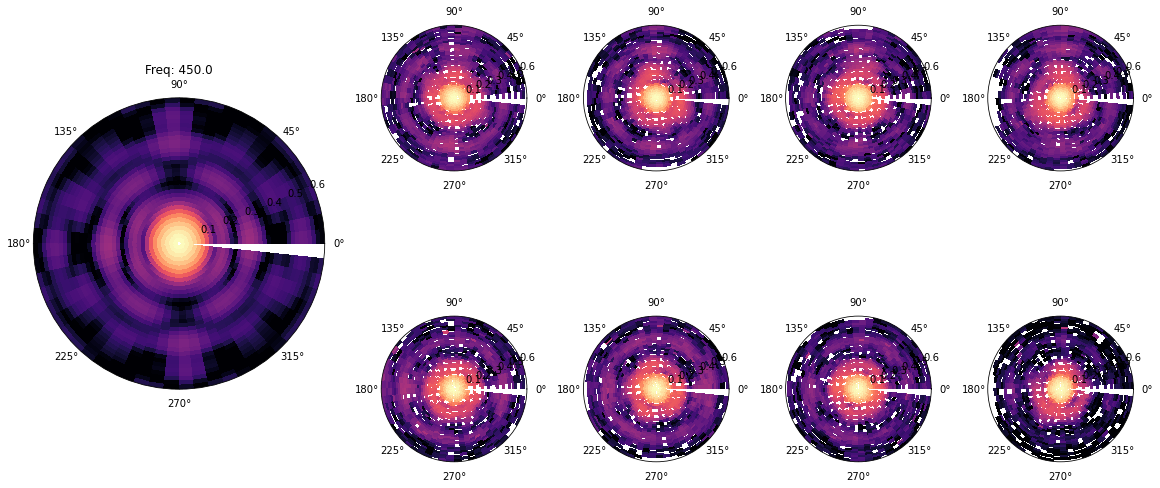

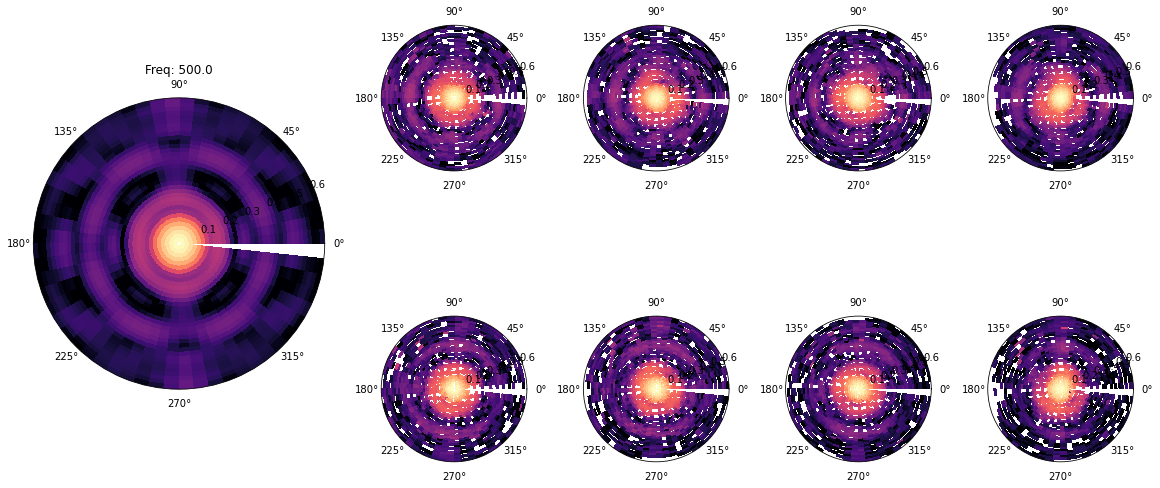

<ipython-input-46-4ab28ec1f235>:65: RuntimeWarning: divide by zero encountered in log10
  ptest.d1_centers_grid[:,:,chind],10*np.log10(ptest.V_LC_operation[:,:,0,chind]),
<ipython-input-46-4ab28ec1f235>:80: RuntimeWarning: divide by zero encountered in log10
  ptest.d1_centers_grid[:,:,chind],10*np.log10(ptest.V_LC_operation[:,:,0,chind]),


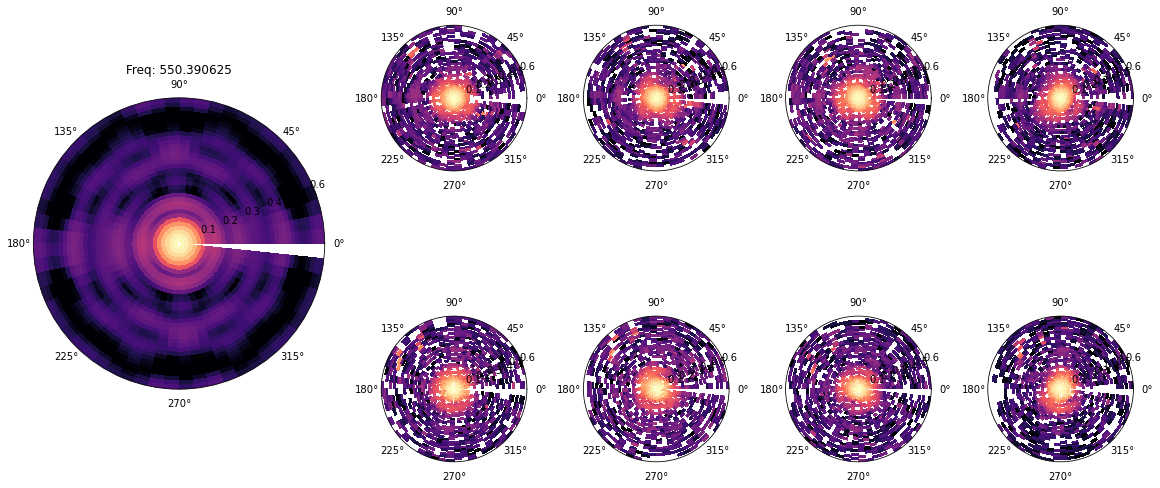

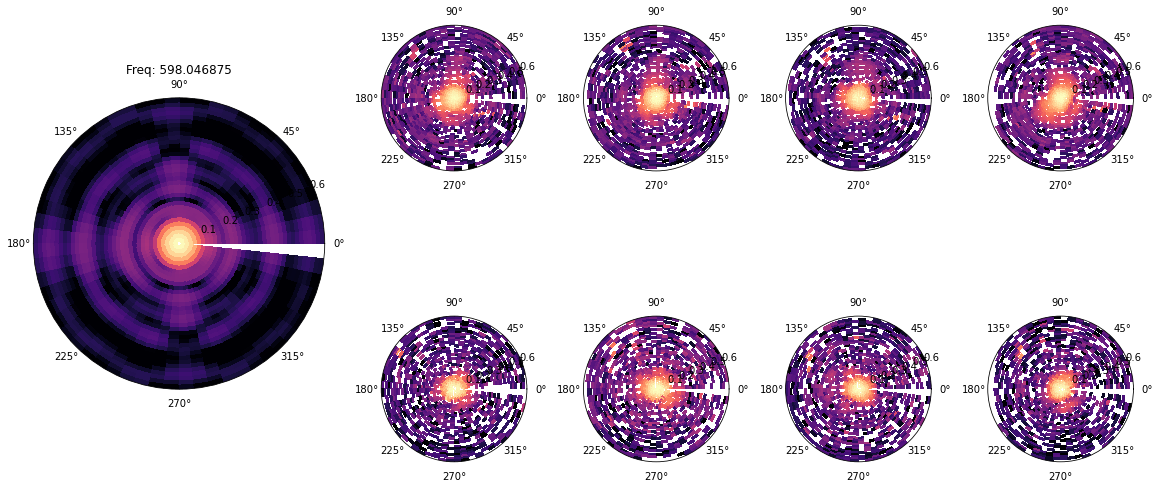

In [46]:
#### Halleluia, some consistency, lets start on some plots now


## This plots the sims, and each coadded map, for the nearest data frequency

finds = [896,768,639,517]
simfr = [450,500,550,600]

for ff,find in enumerate(finds):
    # Figure setup stuff
    fig = plt.figure(constrained_layout=True,figsize=(16,8))
    gs = GridSpec(2,5, height_ratios=[0.5,0.5], width_ratios=[1,0.5,0.5,0.5,0.5],figure=fig)
    axs0 = fig.add_subplot(gs[:,0],polar=True)
    axs1 = fig.add_subplot(gs[0, 1],polar=True)
    axs2 = fig.add_subplot(gs[0, 2],polar=True)
    axs3 = fig.add_subplot(gs[0, 3],polar=True)
    axs4 = fig.add_subplot(gs[0, 4],polar=True)
    axs5 = fig.add_subplot(gs[1, 1],polar=True)
    axs6 = fig.add_subplot(gs[1, 2],polar=True)
    axs7 = fig.add_subplot(gs[1, 3],polar=True)
    axs8 = fig.add_subplot(gs[1, 4],polar=True)
    
    # Open N pol coadd - need this for the sim gridding
    copoldir = 'N'
    chind = N_pols[0]
    picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
    with open(picklefile, 'rb') as inp:
        ptest = pickle.load(inp)
     

    # simulation map at this frequency
    # Bin to the same grid as the data 
    freq = simfr[ff]
    amp = max(dfs_sims[freq]['mag'][1])
    xpos = dfs_sims[freq]['position'][0].to_numpy()
    ypos = dfs_sims[freq]['position'][1].to_numpy()
    zpos = (dfs_sims[freq]['mag'][1].to_numpy()/amp)**2

    r = np.radians(np.sqrt(xpos**2 + ypos**2))
    thet = np.arctan2(ypos,xpos)
    thet[thet<0.0] += 2*np.pi
    xedges = ptest.d0_edges_grid[:,0,chind]
    yedges = ptest.d1_edges_grid[0,:,chind]

    binnedmap = binned_statistic_2d(x=thet,y=r,values=zpos,
                                statistic='mean',bins=[xedges,yedges]).statistic


    axs0.pcolormesh(ptest.d0_centers_grid[:,:,chind],
               ptest.d1_centers_grid[:,:,chind],10*np.log10(binnedmap),cmap=ccm,vmin=-40,vmax=0)
    axs0.set_title('Freq: '+str(freqs[find]))

    
    # Now the per-input plots - N pol
    chind=N_pols[0]
    axs1.pcolormesh(ptest.d0_centers_grid[:,:,chind],
               ptest.d1_centers_grid[:,:,chind],10*np.log10(ptest.V_LC_operation[:,:,0,chind]),
                cmap=ccm,vmin=-40,vmax=0)
    chind=N_pols[1]
    axs2.pcolormesh(ptest.d0_centers_grid[:,:,chind],
               ptest.d1_centers_grid[:,:,chind],10*np.log10(ptest.V_LC_operation[:,:,0,chind]),
                cmap=ccm,vmin=-40,vmax=0)
    chind=N_pols[2]
    axs3.pcolormesh(ptest.d0_centers_grid[:,:,chind],
               ptest.d1_centers_grid[:,:,chind],10*np.log10(ptest.V_LC_operation[:,:,0,chind]),
                cmap=ccm,vmin=-40,vmax=0)
    chind=N_pols[3]
    axs4.pcolormesh(ptest.d0_centers_grid[:,:,chind],
               ptest.d1_centers_grid[:,:,chind],10*np.log10(ptest.V_LC_operation[:,:,0,chind]),
                cmap=ccm,vmin=-40,vmax=0)

    # Now the per-input plots - E pol
    copoldir = 'E'
    picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
    with open(picklefile, 'rb') as inp:
        ptest = pickle.load(inp)
    
    chind=E_pols[0]
    axs5.pcolormesh(ptest.d0_centers_grid[:,:,chind],
               ptest.d1_centers_grid[:,:,chind],10*np.log10(ptest.V_LC_operation[:,:,0,chind]),
                cmap=ccm,vmin=-40,vmax=0)
    chind=E_pols[1]
    axs6.pcolormesh(ptest.d0_centers_grid[:,:,chind],
               ptest.d1_centers_grid[:,:,chind],10*np.log10(ptest.V_LC_operation[:,:,0,chind]),
                cmap=ccm,vmin=-40,vmax=0)
    chind=E_pols[2]
    axs7.pcolormesh(ptest.d0_centers_grid[:,:,chind],
               ptest.d1_centers_grid[:,:,chind],10*np.log10(ptest.V_LC_operation[:,:,0,chind]),
                cmap=ccm,vmin=-40,vmax=0)
    chind=E_pols[3]
    axs8.pcolormesh(ptest.d0_centers_grid[:,:,chind],
               ptest.d1_centers_grid[:,:,chind],10*np.log10(ptest.V_LC_operation[:,:,0,chind]),
                cmap=ccm,vmin=-40,vmax=0)
    plt.show()
    



<ipython-input-17-2f095df9ff79>:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs0.pcolormesh(ptest.d0_centers_grid[:,:,chind],
<ipython-input-17-2f095df9ff79>:75: RuntimeWarning: Mean of empty slice
  ptest.d1_centers_grid[:,:,chind],10*np.log10(np.nanmean(holder[:,:,chind,:],axis=-1)),
<ipython-input-17-2f095df9ff79>:75: RuntimeWarning: invalid value encountered in log10
  ptest.d1_centers_grid[:,:,chind],10*np.log10(np.nanmean(holder[:,:,chind,:],axis=-1)),
<ipython-input-17-2f095df9ff79>:74: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', o

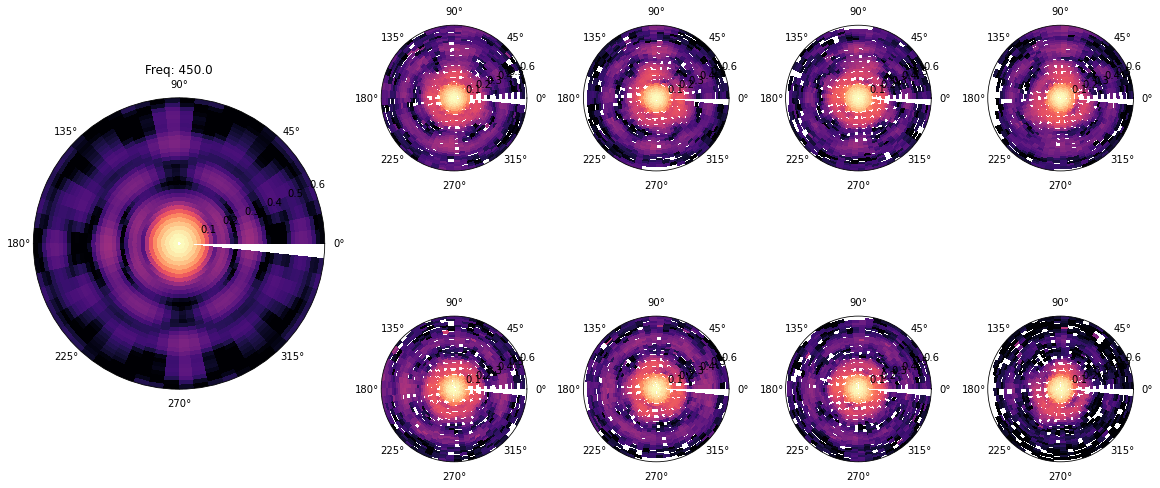

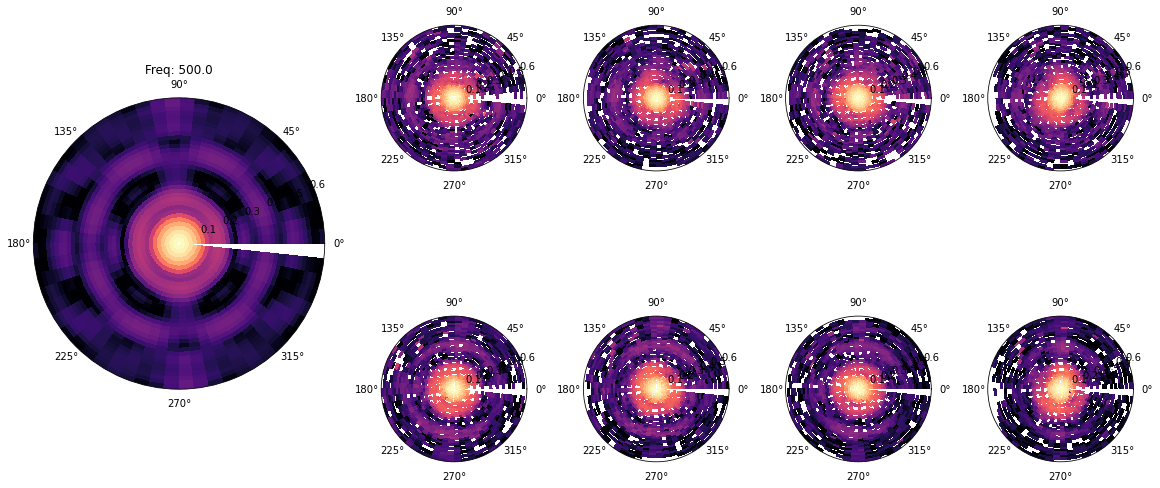

<ipython-input-17-2f095df9ff79>:102: RuntimeWarning: divide by zero encountered in log10
  ptest.d1_centers_grid[:,:,chind],10*np.log10(ptest.V_LC_operation[:,:,0,chind]),


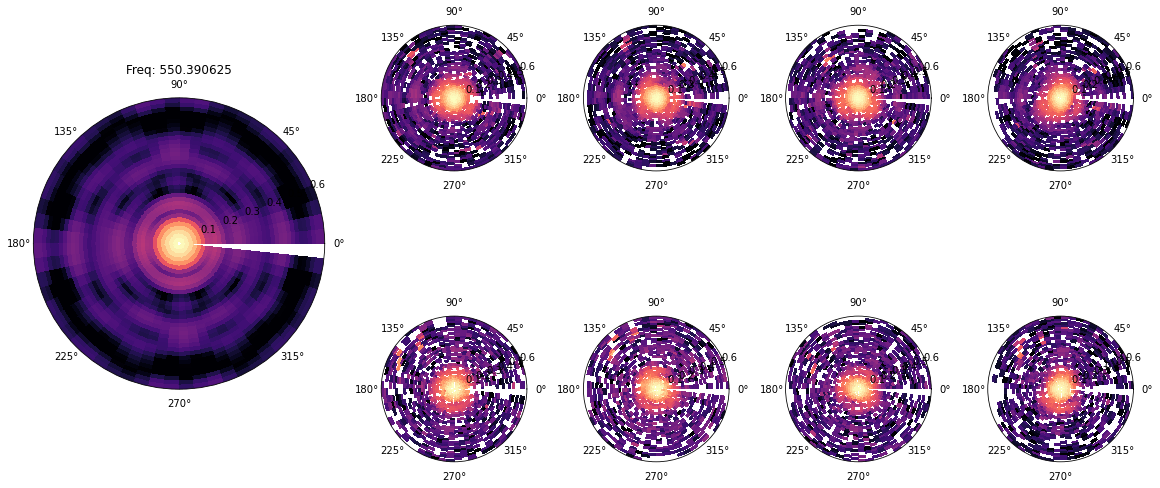

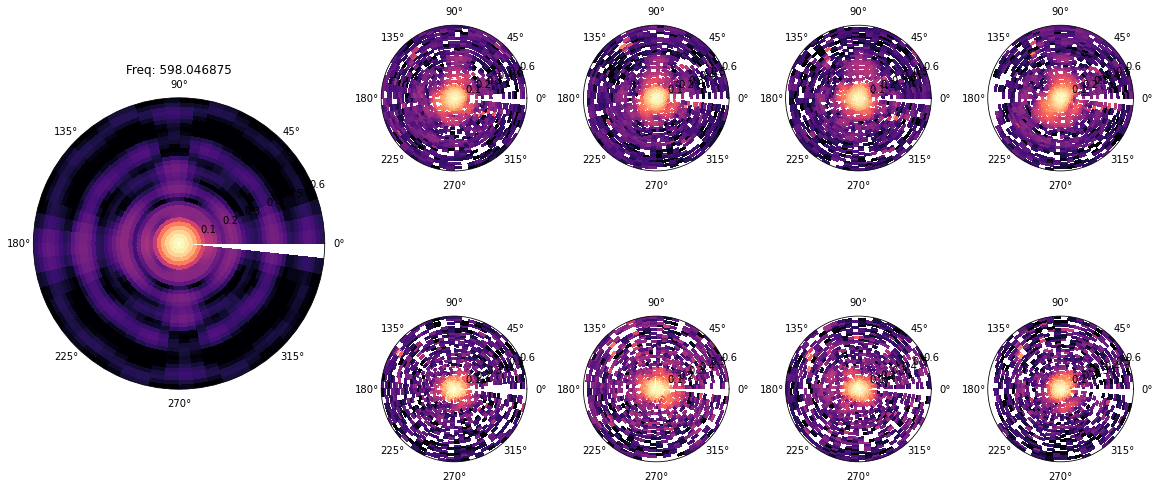

In [17]:
## This plots the sims, and each coadded map, with an average over a few nearby frequencies for data

finds = [896,768,639,517]
simfr = [450,500,550,600]

def get_ffs(find):
    if find==896: fset = [895,896,892]
    elif find == 768: fset = [768,788]
    elif find == 639: fset = [639,636,645]
    elif find == 517: fset = [517,518,519]
    return fset
    
    

for ff,find in enumerate(finds):
    # Figure setup stuff
    fig = plt.figure(constrained_layout=True,figsize=(16,8))
    gs = GridSpec(2,5, height_ratios=[0.5,0.5], width_ratios=[1,0.5,0.5,0.5,0.5],figure=fig)
    axs0 = fig.add_subplot(gs[:,0],polar=True)
    axs1 = fig.add_subplot(gs[0, 1],polar=True)
    axs2 = fig.add_subplot(gs[0, 2],polar=True)
    axs3 = fig.add_subplot(gs[0, 3],polar=True)
    axs4 = fig.add_subplot(gs[0, 4],polar=True)
    axs5 = fig.add_subplot(gs[1, 1],polar=True)
    axs6 = fig.add_subplot(gs[1, 2],polar=True)
    axs7 = fig.add_subplot(gs[1, 3],polar=True)
    axs8 = fig.add_subplot(gs[1, 4],polar=True)
    
    # Open N pol coadd - need this for the sim gridding
    copoldir = 'N'
    chind = N_pols[0]
    picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
    with open(picklefile, 'rb') as inp:
        ptest = pickle.load(inp)
     

    # simulation map at this frequency
    freq = simfr[ff]
    amp = max(dfs_sims[freq]['mag'][1])
    xpos = dfs_sims[freq]['position'][0].to_numpy()
    ypos = dfs_sims[freq]['position'][1].to_numpy()
    zpos = (dfs_sims[freq]['mag'][1].to_numpy()/amp)**2

    r = np.radians(np.sqrt(xpos**2 + ypos**2))
    thet = np.arctan2(ypos,xpos)
    thet[thet<0.0] += 2*np.pi
    xedges = ptest.d0_edges_grid[:,0,chind]
    yedges = ptest.d1_edges_grid[0,:,chind]

    binnedmap = binned_statistic_2d(x=thet,y=r,values=zpos,
                                statistic='mean',bins=[xedges,yedges]).statistic


    axs0.pcolormesh(ptest.d0_centers_grid[:,:,chind],
               ptest.d1_centers_grid[:,:,chind],10*np.log10(binnedmap),cmap=ccm,vmin=-40,vmax=0)
    axs0.set_title('Freq: '+str(freqs[find]))

    
    # Now the per-input plots - N pol
    
    ffs = get_ffs(find)
    holder = np.NAN*np.ones([60,36,16,len(ffs)])
    
    for fi,fdat in enumerate(ffs):
        picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(fdat)+'_polar.pkl'
        with open(picklefile, 'rb') as inp:
            ptest = pickle.load(inp)
    
        holder[:,:,:,fi] = ptest.V_LC_operation[:,:,0,:]

    
    
    chind=N_pols[0]
    axs1.pcolormesh(ptest.d0_centers_grid[:,:,chind],
               ptest.d1_centers_grid[:,:,chind],10*np.log10(np.nanmean(holder[:,:,chind,:],axis=-1)),
                cmap=ccm,vmin=-40,vmax=0)
    chind=N_pols[1]
    axs2.pcolormesh(ptest.d0_centers_grid[:,:,chind],
               ptest.d1_centers_grid[:,:,chind],10*np.log10(np.nanmean(holder[:,:,chind,:],axis=-1)),
                cmap=ccm,vmin=-40,vmax=0)
    chind=N_pols[2]
    axs3.pcolormesh(ptest.d0_centers_grid[:,:,chind],
               ptest.d1_centers_grid[:,:,chind],10*np.log10(np.nanmean(holder[:,:,chind,:],axis=-1)),
                cmap=ccm,vmin=-40,vmax=0)
    chind=N_pols[3]
    axs4.pcolormesh(ptest.d0_centers_grid[:,:,chind],
               ptest.d1_centers_grid[:,:,chind],10*np.log10(np.nanmean(holder[:,:,chind,:],axis=-1)),
                cmap=ccm,vmin=-40,vmax=0)

    # Now the per-input plots - E pol
    copoldir = 'E'
    picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
    with open(picklefile, 'rb') as inp:
        ptest = pickle.load(inp)
    
    chind=E_pols[0]
    axs5.pcolormesh(ptest.d0_centers_grid[:,:,chind],
               ptest.d1_centers_grid[:,:,chind],10*np.log10(ptest.V_LC_operation[:,:,0,chind]),
                cmap=ccm,vmin=-40,vmax=0)
    chind=E_pols[1]
    axs6.pcolormesh(ptest.d0_centers_grid[:,:,chind],
               ptest.d1_centers_grid[:,:,chind],10*np.log10(ptest.V_LC_operation[:,:,0,chind]),
                cmap=ccm,vmin=-40,vmax=0)
    chind=E_pols[2]
    axs7.pcolormesh(ptest.d0_centers_grid[:,:,chind],
               ptest.d1_centers_grid[:,:,chind],10*np.log10(ptest.V_LC_operation[:,:,0,chind]),
                cmap=ccm,vmin=-40,vmax=0)
    chind=E_pols[3]
    axs8.pcolormesh(ptest.d0_centers_grid[:,:,chind],
               ptest.d1_centers_grid[:,:,chind],10*np.log10(ptest.V_LC_operation[:,:,0,chind]),
                cmap=ccm,vmin=-40,vmax=0)
    plt.show()
    



<ipython-input-24-c4454f01f847>:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs[ff,0].pcolormesh(ptest.d0_centers_grid[:,:,chind],
<ipython-input-24-c4454f01f847>:47: RuntimeWarning: Mean of empty slice
  N_holder[:,:,fi] = np.nanmean(ptest.V_LC_operation[:,:,0,N_pols],axis=-1)
<ipython-input-24-c4454f01f847>:49: RuntimeWarning: Mean of empty slice
  N_map = np.nanmean(N_holder,axis=-1)
<ipython-input-24-c4454f01f847>:51: RuntimeWarning: invalid value encountered in log10
  ptest.d1_centers_grid[:,:,chind],10*np.log10(N_map[:,:]),
<ipython-input-24-c4454f01f847>:50: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quad

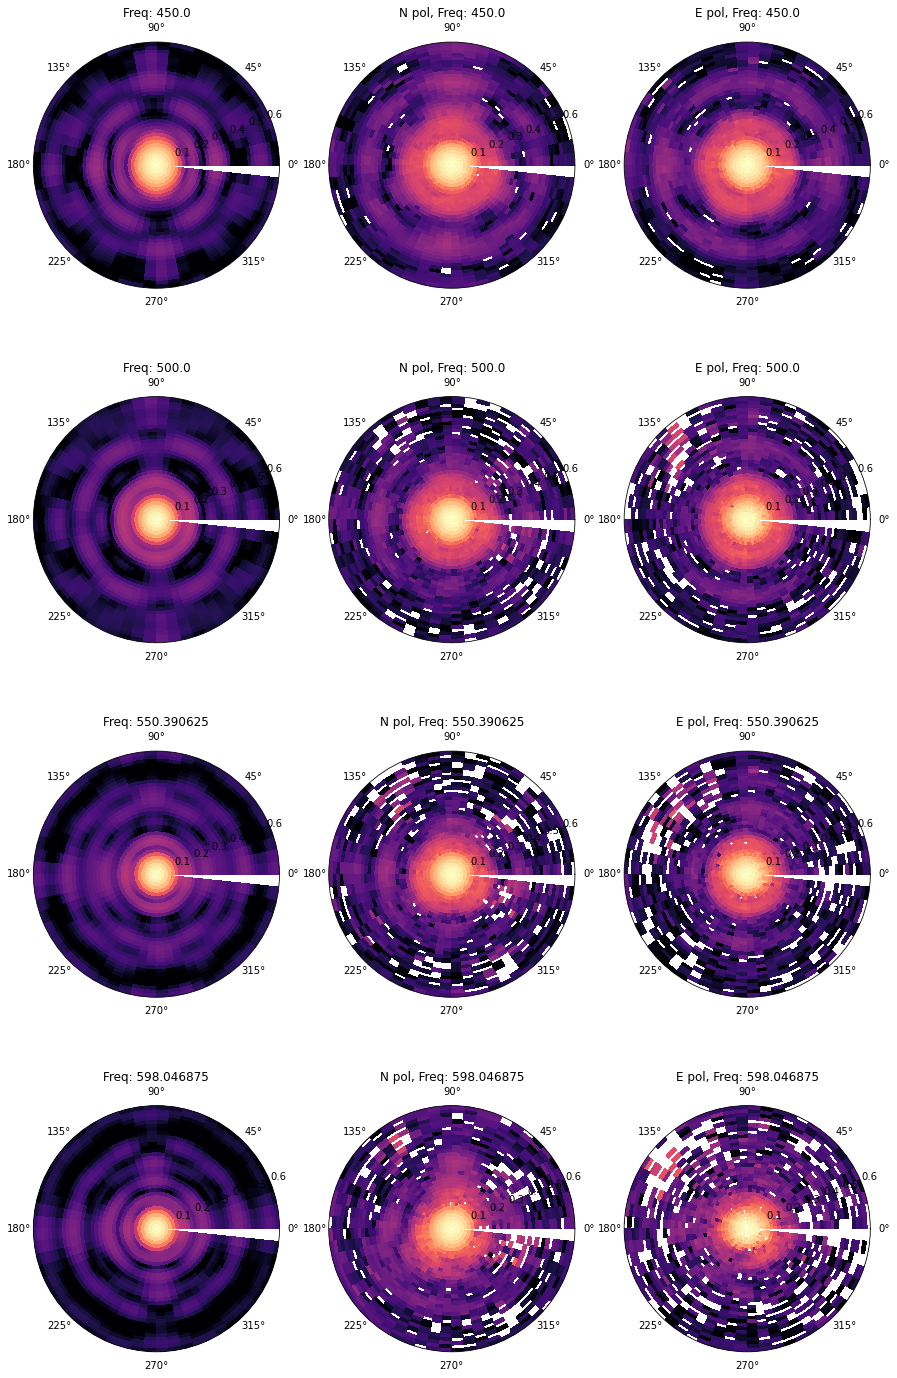

In [24]:
# Average together N pols, and a few frequencies, and see what happens

fig, axs = plt.subplots(4,3, subplot_kw=dict(projection="polar"),figsize=(15,25))


for ff,find in enumerate(finds):
    
    # Open N pol coadd - need this for the sim gridding
    copoldir = 'N'
    chind = N_pols[0]
    picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
    with open(picklefile, 'rb') as inp:
        ptest = pickle.load(inp)
     

    # simulation map at this frequency
    freq = simfr[ff]
    amp = max(dfs_sims[freq]['mag'][1])
    xpos = dfs_sims[freq]['position'][0].to_numpy()
    ypos = dfs_sims[freq]['position'][1].to_numpy()
    zpos = (dfs_sims[freq]['mag'][1].to_numpy()/amp)**2

    r = np.radians(np.sqrt(xpos**2 + ypos**2))
    thet = np.arctan2(ypos,xpos)
    thet[thet<0.0] += 2*np.pi
    xedges = ptest.d0_edges_grid[:,0,chind]
    yedges = ptest.d1_edges_grid[0,:,chind]

    binnedmap = binned_statistic_2d(x=thet,y=r,values=zpos,
                                statistic='mean',bins=[xedges,yedges]).statistic
    
    axs[ff,0].pcolormesh(ptest.d0_centers_grid[:,:,chind],
               ptest.d1_centers_grid[:,:,chind],10*np.log10(binnedmap),cmap=ccm,vmin=-40,vmax=0)
    axs[ff,0].set_title('Freq: '+str(freqs[find]))
    
    # Open N pol coadd
    copoldir = 'N'
    
    ffs = get_ffs(find)
    N_holder = np.NAN*np.ones([60,36,len(ffs)])
    
    for fi,fdat in enumerate(ffs):
        picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(fdat)+'_polar.pkl'
        with open(picklefile, 'rb') as inp:
            ptest = pickle.load(inp)
    
        N_holder[:,:,fi] = np.nanmean(ptest.V_LC_operation[:,:,0,N_pols],axis=-1)

    N_map = np.nanmean(N_holder,axis=-1)
    axs[ff,1].pcolormesh(ptest.d0_centers_grid[:,:,chind],
               ptest.d1_centers_grid[:,:,chind],10*np.log10(N_map[:,:]),
                cmap=ccm,vmin=-40,vmax=0)
    axs[ff,1].set_title('N pol, Freq: '+str(freqs[find]))

    
    # Open E pol coadd
    copoldir = 'E'
    
    ffs = get_ffs(find)
    E_holder = np.NAN*np.ones([60,36,len(ffs)])
    
    for fi,fdat in enumerate(ffs):
        picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(fdat)+'_polar.pkl'
        with open(picklefile, 'rb') as inp:
            ptest = pickle.load(inp)
    
        E_holder[:,:,fi] = np.nanmean(ptest.V_LC_operation[:,:,0,E_pols],axis=-1)
        
    E_map = np.nanmean(E_holder,axis=-1)

    axs[ff,2].pcolormesh(ptest.d0_centers_grid[:,:,chind],
               ptest.d1_centers_grid[:,:,chind],10*np.log10(E_map[:,:]),
                cmap=ccm,vmin=-40,vmax=0)
    axs[ff,2].set_title('E pol, Freq: '+str(freqs[find]))
    
    
axs[ff,0].set_ylim(0,0.6)
axs[ff,1].set_ylim(0,0.6)
axs[ff,2].set_ylim(0,0.6)
plt.show()



Freqs:  450 450.0


<ipython-input-40-85de07a17792>:35: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-40-85de07a17792>:35: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-40-85de07a17792>:35: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-40-85de07a17792>:35: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-40-85de07a17792>:58: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),
<ipython-input-40-85de07a17792>:58: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),
<ipython-input-40-85de07a17792>:35: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipy

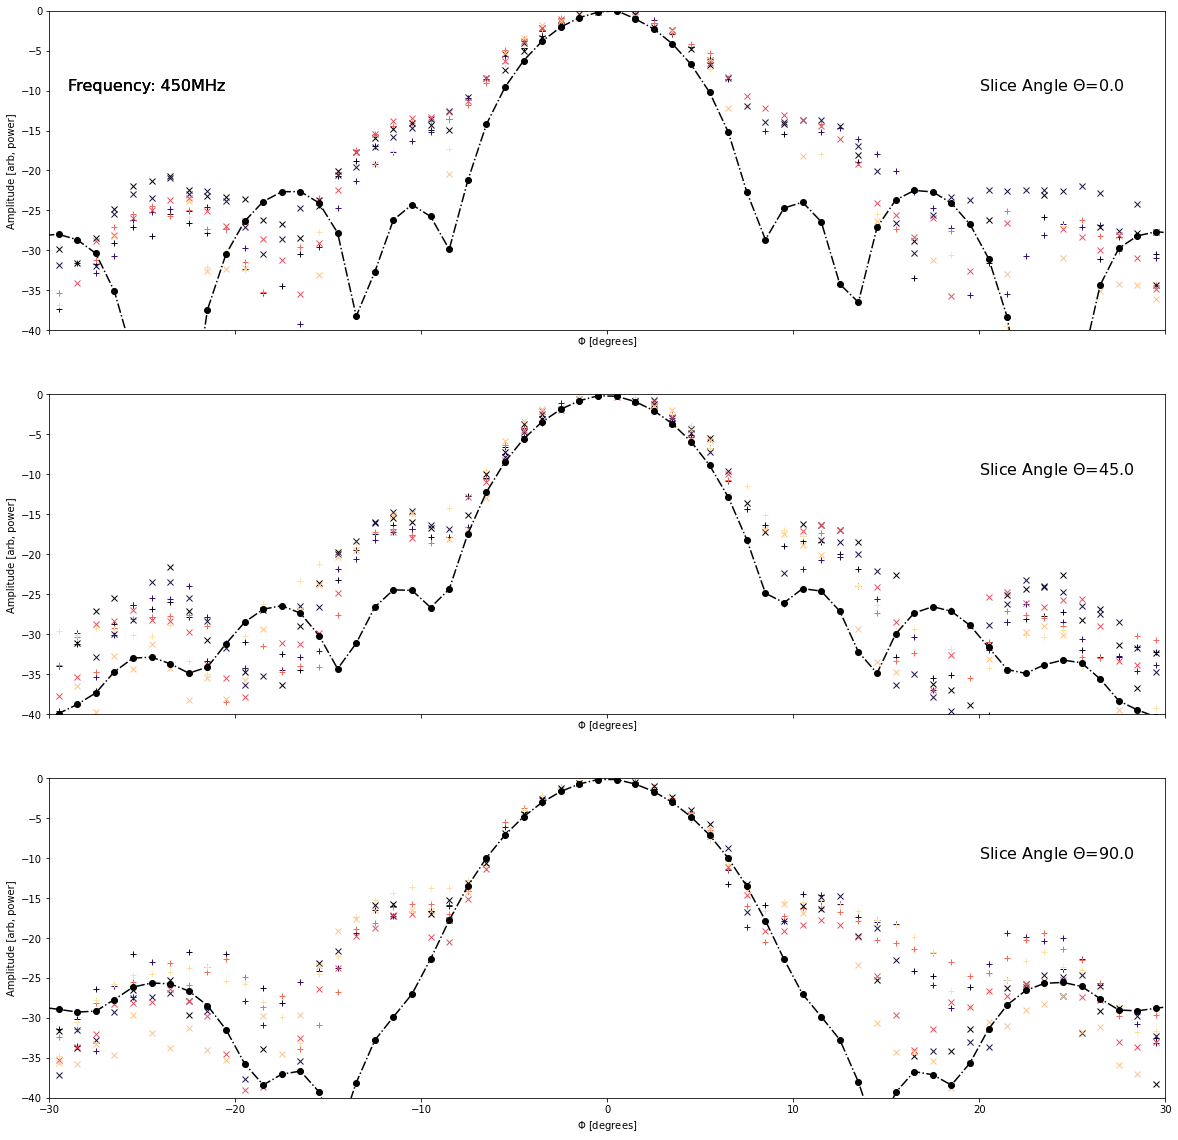

Freqs:  500 500.0


<ipython-input-40-85de07a17792>:35: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-40-85de07a17792>:35: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-40-85de07a17792>:35: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-40-85de07a17792>:58: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),
<ipython-input-40-85de07a17792>:58: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),
<ipython-input-40-85de07a17792>:58: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),
<ipython-input-40-85de07a17792>:58: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),
<ipython-input-40-85de07a17792>:35: RuntimeW

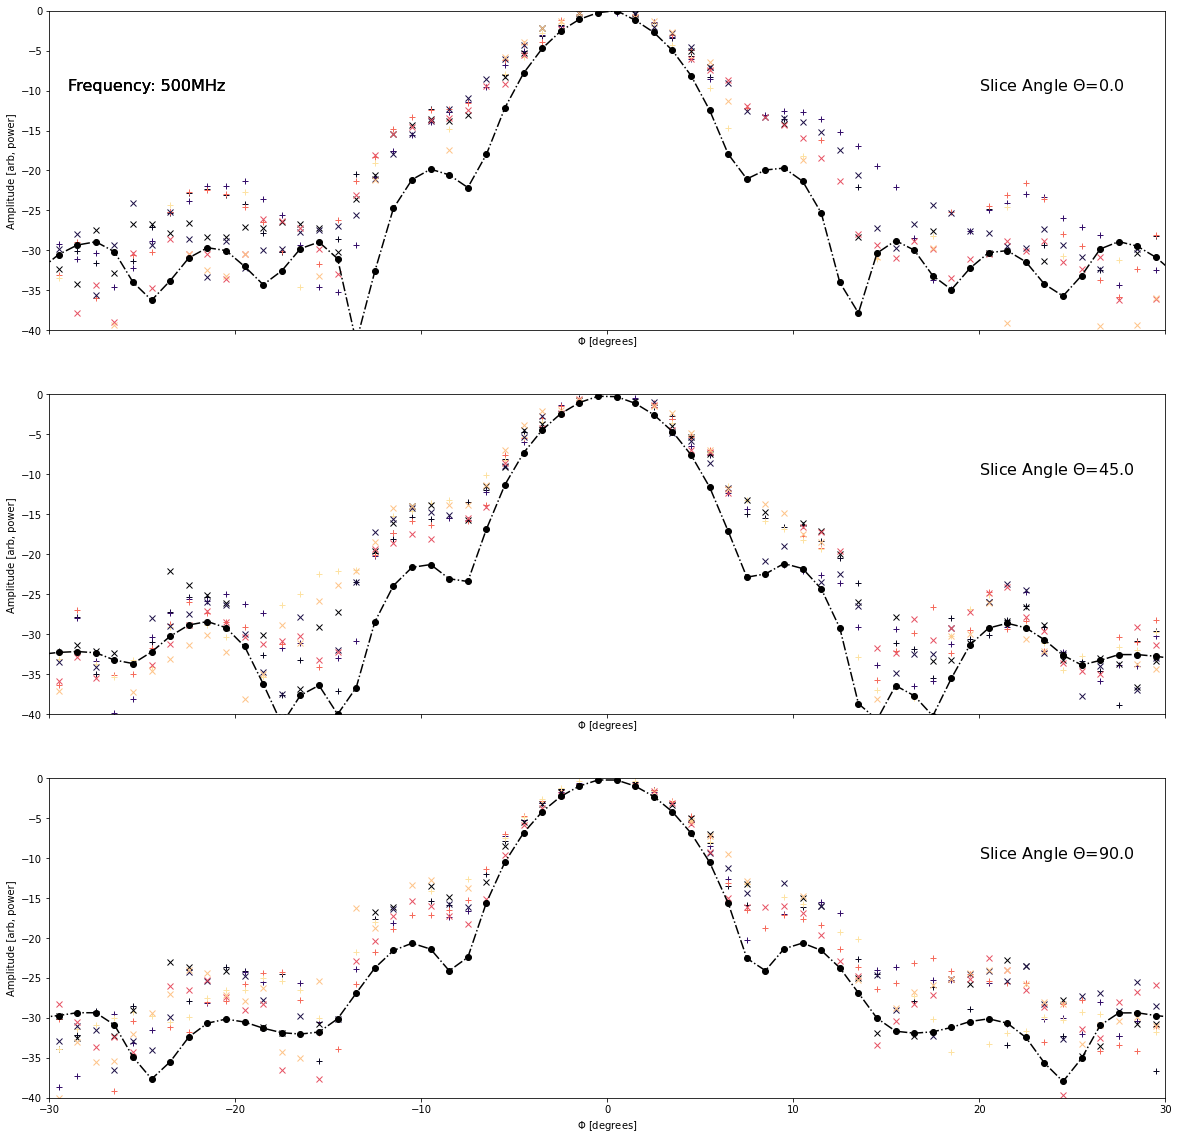

Freqs:  550 550.390625


<ipython-input-40-85de07a17792>:35: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-40-85de07a17792>:35: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-40-85de07a17792>:35: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-40-85de07a17792>:35: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-40-85de07a17792>:58: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),
<ipython-input-40-85de07a17792>:58: RuntimeWarning: divide by zero encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),
<ipython-input-40-85de07a17792>:58: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),
<ipython-input-40-85de0

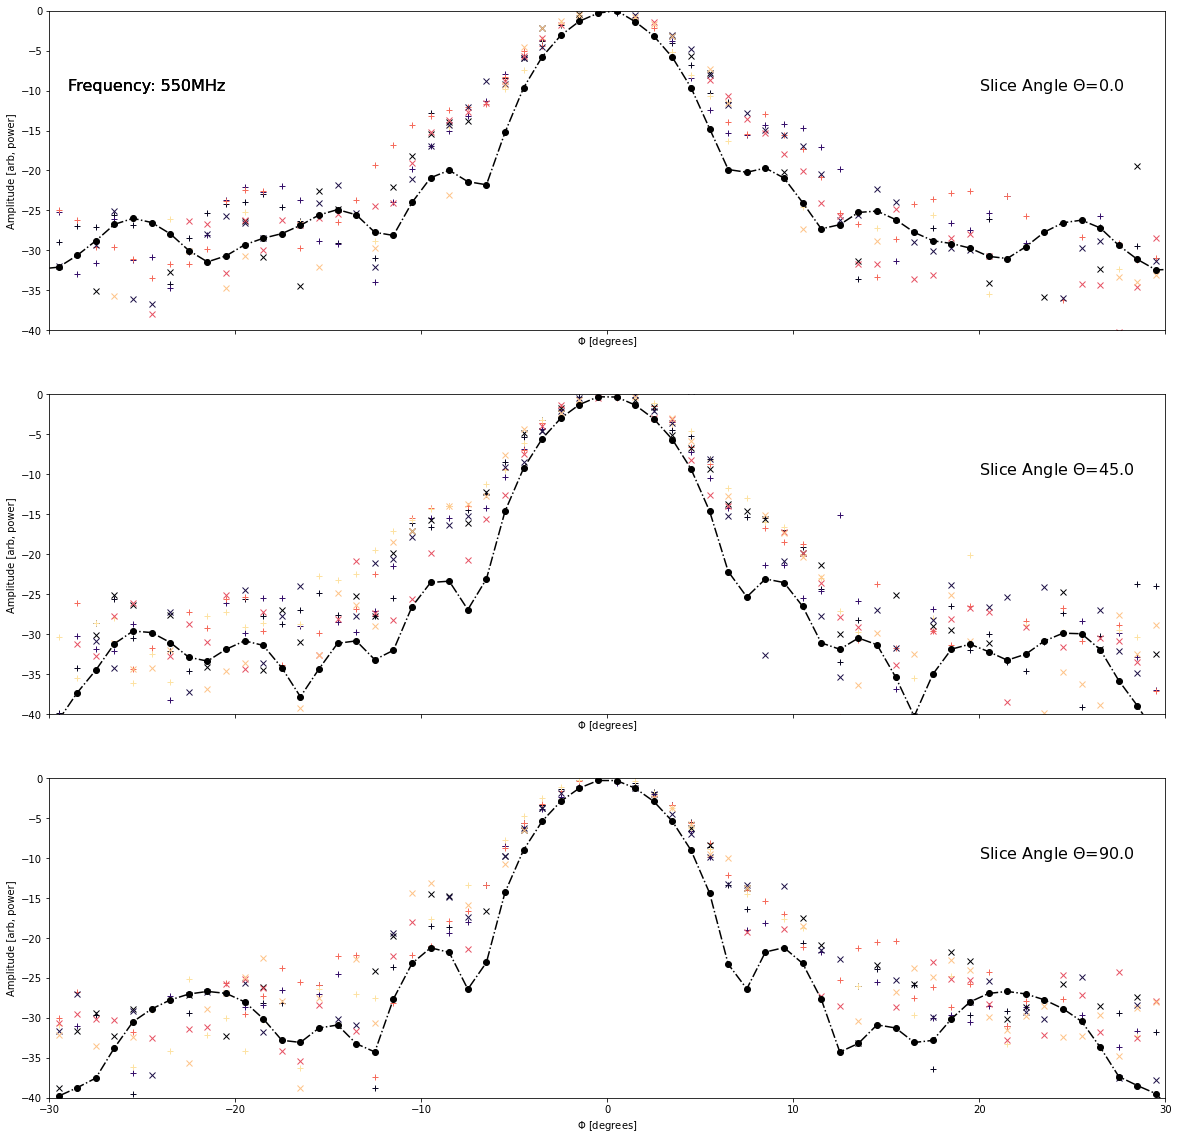

Freqs:  600 598.046875


<ipython-input-40-85de07a17792>:35: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-40-85de07a17792>:35: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-40-85de07a17792>:35: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-40-85de07a17792>:35: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-40-85de07a17792>:58: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),
<ipython-input-40-85de07a17792>:58: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),
<ipython-input-40-85de07a17792>:58: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),
<ipython-input-40-85de07

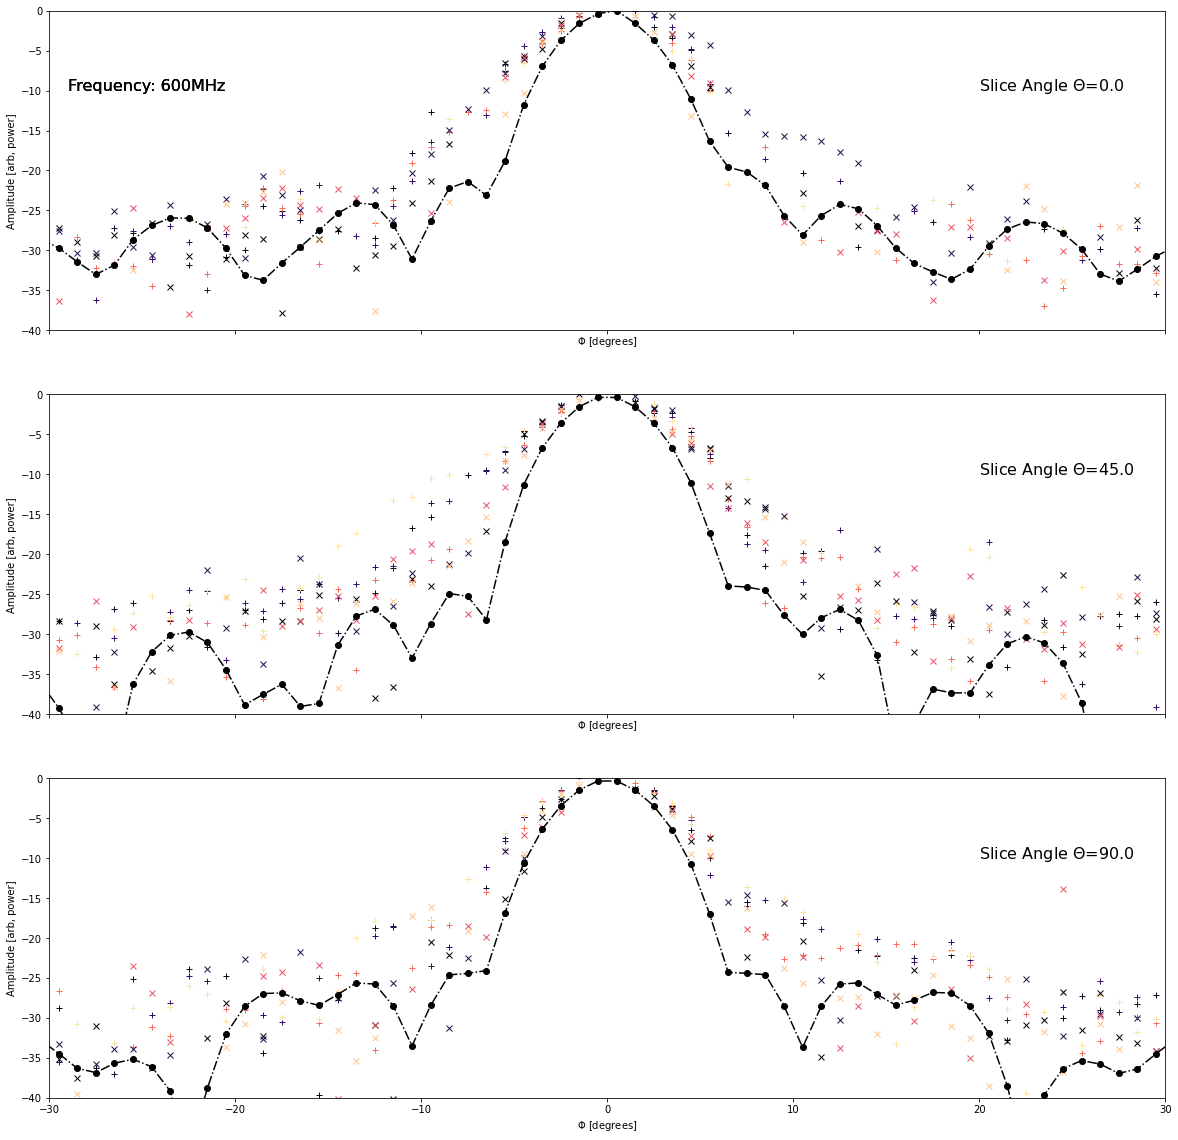

In [40]:
### Let's work up to plotting slices now. Remove gaussian fits

whichang = [0.0, np.pi/4.0, np.pi/2.]

for ff,find in enumerate(finds):
    
    print('Freqs: ', simfr[ff],freqs[find])
    
    fig,axs = plt.subplots(3, 1,figsize=(20,20),sharex=True,sharey=True)
        
    for a, ang in enumerate(whichang):

        # N pol next
        copoldir = 'N'
        pols = N_pols

        picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
        with open(picklefile, 'rb') as inp:
            ptest = pickle.load(inp)

        for p,chind in enumerate(N_pols): 
            ppos = np.degrees(ptest.d1_centers_grid[:,:,chind])
            tpos = ptest.d0_centers_grid[:,:,chind]
            dzpos = ptest.V_LC_operation[:,:,0,chind]

            # grab a polar slice at a given angle
            ppos = np.degrees(ptest.d1_centers_grid[:,:,chind])
            tpos = ptest.d0_centers_grid[:,:,chind]
            dzpos = ptest.V_LC_operation[:,:,0,chind]
    
            cc1,cc2 = get_polar_slice(tpos,ppos,val=ang,direction='t')
        
            pposc = np.concatenate((ppos[cc1,:],-1.0*ppos[cc2,:]))
            dzposc = np.concatenate((dzpos[cc1,:],dzpos[cc2,:]))
            axs[a].plot(pposc,10*np.log10(dzposc),color=colorz[chind],
                    marker='+',linestyle='None')
        
        # E pol next
        copoldir = 'E'
        pols = E_pols

        picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
        with open(picklefile, 'rb') as inp:
            ptest = pickle.load(inp)
        
        for p,chind in enumerate(E_pols): 
            ppos = np.degrees(ptest.d1_centers_grid[:,:,chind])
            tpos = ptest.d0_centers_grid[:,:,chind]
            dzpos = ptest.V_LC_operation[:,:,0,chind]

            # grab a polar slice at a given angle
            ppos = np.degrees(ptest.d1_centers_grid[:,:,chind])
            tpos = ptest.d0_centers_grid[:,:,chind]
            dzpos = ptest.V_LC_operation[:,:,0,chind]
        
            pposc = np.concatenate((ppos[cc1,:],-1.0*ppos[cc2,:]))
            dzposc = np.concatenate((dzpos[cc1,:],dzpos[cc2,:]))
            axs[a].plot(pposc,10*np.log10(dzposc),
                    color=colorz[chind],marker='x',linestyle='None')
        
        # Sim 
        freq = simfr[ff]
        amp = max(dfs_sims[freq]['mag'][1])
        xpos = dfs_sims[freq]['position'][0].to_numpy()
        ypos = dfs_sims[freq]['position'][1].to_numpy()
        zpos = (dfs_sims[freq]['mag'][1].to_numpy()/amp)**2

        r = np.radians(np.sqrt(xpos**2 + ypos**2))
        thet = np.arctan2(ypos,xpos)
        thet[thet<0.0] += 2*np.pi
        xedges = ptest.d0_edges_grid[:,0,chind]
        yedges = ptest.d1_edges_grid[0,:,chind]

        binnedmap = binned_statistic_2d(x=thet,y=r,values=zpos,
                                statistic='mean',bins=[xedges,yedges]).statistic
    
        #simx = np.concatenate((r[cc1,:],-1.0*r[cc2,:]))
        simz = np.concatenate((binnedmap[cc1,:][::-1],binnedmap[cc2,:]))
        pposc = np.concatenate((ppos[cc1,:][::-1],-1.0*ppos[cc2,:]))
        axs[a].plot(pposc,10*np.log10(simz),color='black',
                    marker='o',linestyle='-.')
        
        axs[a].text(20,-10,r'Slice Angle $\Theta$='+ str(np.degrees(ang)),fontsize=16)
        axs[a].set_xlabel(r'$\Phi$ [degrees]')
        axs[a].set_ylabel('Amplitude [arb, power]')
        axs[0].text(-29,-10,'Frequency: '+str(simfr[ff])+'MHz',fontsize=16)
        axs[a].set_xlim(-30,30)
        axs[a].set_ylim(-40,0)
    
    
    plt.show()

